# NSGA-II Benchmark Notebook

This fresh notebook rebuilds the NSGA-II benchmarking workflow using the refactored
VAMOS package layout. It relies on the programmatic `StudyRunner` utilities so you can
queue problem and backend combinations, reproduce CLI experiments, and visualize the
results interactively.


In [8]:
import sys
import itertools
from types import SimpleNamespace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from vamos import main as vamos_main
from vamos.problem.registry import make_problem_selection
from vamos.study.runner import StudyRunner, StudyTask

plt.style.use("seaborn-v0_8-darkgrid")


In [ ]:
POPULATION_SIZE = vamos_main.POPULATION_SIZE
MAX_EVALUATIONS = vamos_main.MAX_EVALUATIONS
DEFAULT_SEEDS = [vamos_main.SEED]

PROBLEM_GRID = [
    {"problem": "zdt1", "label": "ZDT1 (2 obj)", "n_var": 30},
    #{"problem": "dtlz2", "label": "DTLZ2 (3 obj)", "n_var": 12, "n_obj": 3},
]

INCLUDE_EXTERNAL_BASELINES = True
EXTERNAL_PROBLEM_SOURCE = "native"  # choose "vamos" to wrap internal problems

def detect_engines(candidates):
    engines = []
    for name in candidates:
        try:
            vamos_main._resolve_kernel(name)
        except Exception as exc:
            print(f"Skipping engine '{name}': {exc}")
        else:
            engines.append(name)
    return engines


ENABLED_ENGINES = detect_engines(["numpy", "numba", "moocore", "moocore_v2"])
if not ENABLED_ENGINES:
    raise RuntimeError("No kernel backends available. Install optional extras or adjust the list above.")

AVAILABLE_EXTERNAL = list(vamos_main.EXTERNAL_ALGORITHM_NAMES)
print(f"Benchmarks will use engines: {', '.join(ENABLED_ENGINES)}")
if INCLUDE_EXTERNAL_BASELINES and AVAILABLE_EXTERNAL:
    print(
        "External baselines enabled: "
        + ", ".join(AVAILABLE_EXTERNAL)
        + f" (problem source={EXTERNAL_PROBLEM_SOURCE})"
    )


Benchmarks will use engines: numpy, numba, moocore, moocore_v2
External baselines enabled: pymoo_nsga2, jmetalpy_nsga2, pygmo_nsga2 (problem source=native)


In [10]:
RUN_HISTORY = []

def build_tasks(problems, engines, seeds):
    entries = []
    for spec in problems:
        for engine in engines:
            for seed in seeds:
                entries.append(
                    StudyTask(
                        algorithm="nsgaii",
                        engine=engine,
                        problem=spec["problem"],
                        n_var=spec.get("n_var"),
                        n_obj=spec.get("n_obj"),
                        seed=seed,
                    )
                )
    return entries


def run_external_baselines(problems):
    rows = []
    history = []
    if not INCLUDE_EXTERNAL_BASELINES or not AVAILABLE_EXTERNAL:
        return rows, history

    use_native = EXTERNAL_PROBLEM_SOURCE == "native"
    for spec in problems:
        try:
            selection = make_problem_selection(
                spec["problem"], n_var=spec.get("n_var"), n_obj=spec.get("n_obj")
            )
        except ValueError as exc:
            print(f"Skipping external baselines for {spec['problem']}: {exc}")
            continue

        for alg in AVAILABLE_EXTERNAL:
            print(f"[External] {alg} on {selection.spec.label}")
            try:
                metrics = vamos_main._execute_external_runner(
                    alg,
                    selection,
                    use_native_problem=use_native,
                )
            except ValueError as exc:
                print(f"  {exc}")
                continue
            if metrics is None:
                continue
            rows.append(
                {
                    "problem": selection.spec.key,
                    "label": selection.spec.label,
                    "engine": metrics["engine"],
                    "algorithm": metrics["algorithm"],
                    "seed": vamos_main.SEED,
                    "time_ms": metrics["time_ms"],
                    "evaluations": metrics["evaluations"],
                    "evals_per_sec": metrics["evals_per_sec"],
                    "hv": metrics.get("hv"),
                    "hv_source": metrics.get("hv_source"),
                    "spread": metrics.get("spread"),
                }
            )
            history.append(
                SimpleNamespace(
                    selection=selection,
                    metrics=metrics,
                    task=SimpleNamespace(seed=vamos_main.SEED),
                )
            )
    return rows, history


def run_tasks(tasks, *, export_csv=None):
    global RUN_HISTORY
    RUN_HISTORY = []
    records = []
    runner = StudyRunner(verbose=True)
    tasks_sorted = sorted(tasks, key=lambda t: t.problem)
    export_csv = Path(export_csv) if export_csv else None

    for problem_key, group in itertools.groupby(tasks_sorted, key=lambda t: t.problem):
        group_tasks = list(group)
        print(f"\n=== Running problem: {problem_key} ({len(group_tasks)} tasks) ===")
        export_path = None
        if export_csv is not None:
            export_path = export_csv.with_name(f"{export_csv.stem}_{problem_key}{export_csv.suffix}")
        results = runner.run(group_tasks, export_csv_path=export_path)
        RUN_HISTORY.extend(results)
        for res in results:
            metrics = res.metrics
            records.append(
                {
                    "problem": res.selection.spec.key,
                    "label": res.selection.spec.label,
                    "engine": metrics["engine"],
                    "algorithm": metrics["algorithm"],
                    "seed": res.task.seed,
                    "time_ms": metrics["time_ms"],
                    "evaluations": metrics["evaluations"],
                    "evals_per_sec": metrics["evals_per_sec"],
                    "hv": metrics.get("hv"),
                    "hv_source": metrics.get("hv_source"),
                    "spread": metrics.get("spread"),
                }
            )

    extra_rows, extra_history = run_external_baselines(PROBLEM_GRID)
    records.extend(extra_rows)
    RUN_HISTORY.extend(extra_history)

    df = pd.DataFrame.from_records(records)
    return df, list(RUN_HISTORY)


In [11]:
tasks = build_tasks(PROBLEM_GRID, ENABLED_ENGINES, DEFAULT_SEEDS)
summary_df, latest_results = run_tasks(tasks)
summary_df.sort_values(["problem", "engine"], inplace=True)
summary_df



=== Running problem: dtlz2 (4 tasks) ===
[Study] (1/4) nsgaii | numpy | dtlz2 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: DTLZ2
Description: DTLZ2 with configurable objectives (defaults to 3).
Decision variables: 12
Objectives: 3
Algorithm: NSGAII
Backend: numpy
Population size: 100
Max evaluations: 25000
--------------------------------------------------------------------------------
Algorithm finished
--------------------------------------------------------------------------------
PERFORMANCE RESULTS:
Total time: 544.85 ms
Evaluations: 25000
Evaluations/second: 45884
Final solutions: 100

SOLUTION QUALITY:
  Objective 1 range: [0.000000, 0.000000]
  Objective 2 range: [0.000000, 0.000000]
  Objective 3 range: [0.000000, 0.000000]
  Approximate front spread in f1: 0.000000

Results stored in: results\DTLZ2\nsgaii\numpy\seed_42
[Study] (2/4) nsgaii | numba | dtlz2 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Optimization Stu

[2025-11-17 22:33:02,073] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-17 22:33:02,074] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-17 22:33:02,075] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-17 22:33:02,076] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Algorithm finished
--------------------------------------------------------------------------------
PERFORMANCE RESULTS:
Total time: 992.48 ms
Evaluations: 25000
Evaluations/second: 25189
Final solutions: 100

SOLUTION QUALITY:
  Objective 1 range: [0.000000, 0.999414]
  Objective 2 range: [0.011175, 1.023363]
  Approximate front spread in f1: 1.422446
[External] jmetalpy_nsga2 on ZDT1
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 30
Objectives: 2
Algorithm: jMetalPy NSGA-II
Backend: jmetalpy
Population size: 100
Max evaluations: 25000
--------------------------------------------------------------------------------


[2025-11-17 22:33:05,103] [jmetal.core.algorithm] [DEBUG] Finished!


Algorithm finished
--------------------------------------------------------------------------------
PERFORMANCE RESULTS:
Total time: 3029.95 ms
Evaluations: 25000
Evaluations/second: 8251
Final solutions: 100

SOLUTION QUALITY:
  Objective 1 range: [0.000000, 0.999829]
  Objective 2 range: [0.000416, 1.000711]
  Approximate front spread in f1: 1.414302
[External] pygmo_nsga2 on ZDT1
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 30
Objectives: 2
Algorithm: PyGMO NSGA-II
Backend: pygmo
Population size: 100
Max evaluations: 25000
--------------------------------------------------------------------------------
Skipping pygmo_nsga2: pygmo is not installed. Install it (e.g., via conda) to use this baseline.
[External] pymoo_nsga2 on DTLZ2
  PyMOO baseline currently supports only ZDT1.
[External] jmetalpy_nsga2 on DTLZ2
  jMetalPy baseline currently supports only 

,problem,label,engine,algorithm,seed,time_ms,evaluations,evals_per_sec,hv,hv_source,spread
2,dtlz2,DTLZ2,moocore,nsgaii,42,151.4229,25000,165100.523134,1.825422,MooCoreKernel,1.476892
3,dtlz2,DTLZ2,moocore_v2,nsgaii,42,229.8431,25000,108769.852125,0.177598,MooCoreKernelV2,2.038305
1,dtlz2,DTLZ2,numba,nsgaii,42,107.2169,25000,233172.195841,1.825422,NumbaKernel,0.000000
0,dtlz2,DTLZ2,numpy,nsgaii,42,544.8539,25000,45883.859877,1.825422,NumPyKernel,0.000000
9,zdt1,ZDT1,jmetalpy,jmetalpy_nsga2,42,3029.9523,25000,8250.954974,NaN,None,1.414302
6,zdt1,ZDT1,moocore,nsgaii,42,134.6818,25000,185622.704813,0.110018,MooCoreKernel,1.414151
7,zdt1,ZDT1,moocore_v2,nsgaii,42,116.3818,25000,214810.219403,0.110394,MooCoreKernelV2,1.406494
5,zdt1,ZDT1,numba,nsgaii,42,122.4170,25000,204220.002114,0.110046,NumbaKernel,1.414241
4,zdt1,ZDT1,numpy,nsgaii,42,582.6382,25000,42908.274812,0.110018,NumPyKernel,1.414151
8,zdt1,ZDT1,pymoo,pymoo_nsga2,42,992.4805,25000,25189.411781,NaN,None,1.422446


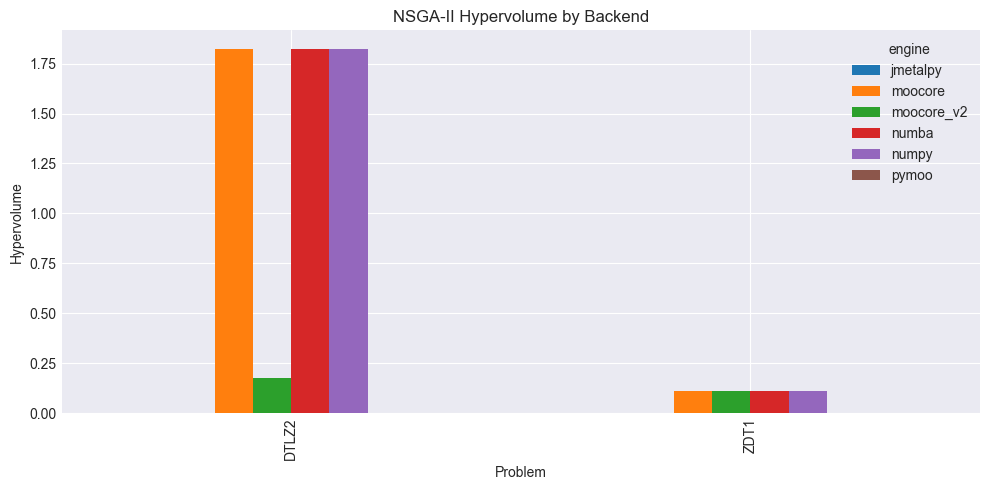

In [12]:
if not summary_df.empty:
    pivot = summary_df.pivot(index="label", columns="engine", values="hv")
    ax = pivot.plot(kind="bar", figsize=(10, 5))
    ax.set_ylabel("Hypervolume")
    ax.set_xlabel("Problem")
    ax.set_title("NSGA-II Hypervolume by Backend")
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize yet. Run the cell above to generate results.")


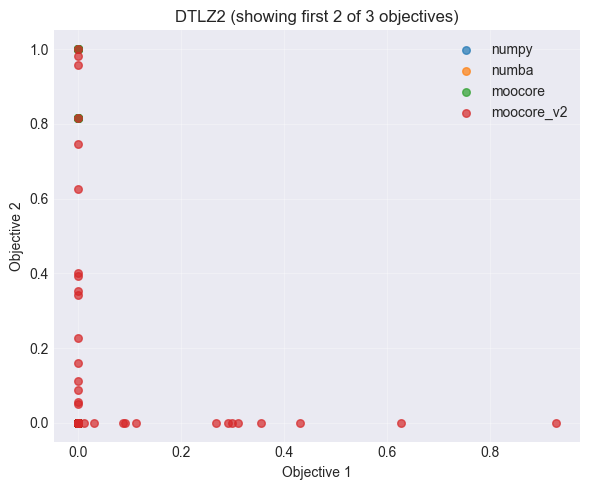

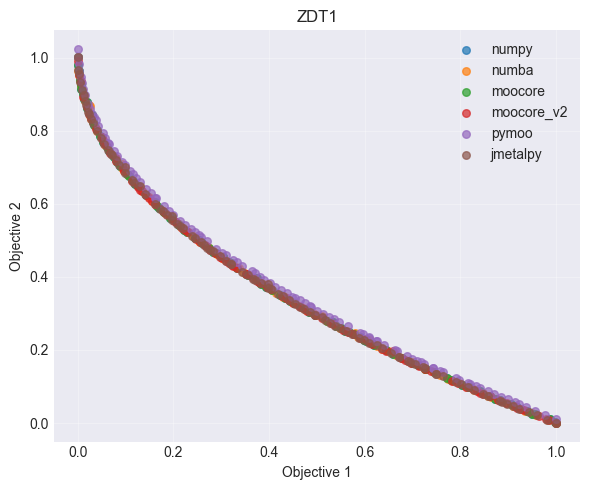

In [13]:
if not RUN_HISTORY:
    print("No results available yet. Run the benchmarking cell above first.")
else:
    problems = {}
    for res in RUN_HISTORY:
        problems.setdefault(res.selection.spec.label, []).append(
            (res.metrics["engine"], res.metrics["F"], res.selection.n_obj)
        )
    for label, entries in problems.items():
        fig, ax = plt.subplots(figsize=(6, 5))
        for engine, front, n_obj in entries:
            front = np.asarray(front)
            dims = front.shape[1]
            coords = front[:, : min(2, dims)]
            ax.scatter(coords[:, 0], coords[:, 1], s=30, alpha=0.7, label=engine)
            if dims > 2:
                ax.set_title(f"{label} (showing first 2 of {dims} objectives)")
            else:
                ax.set_title(label)
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


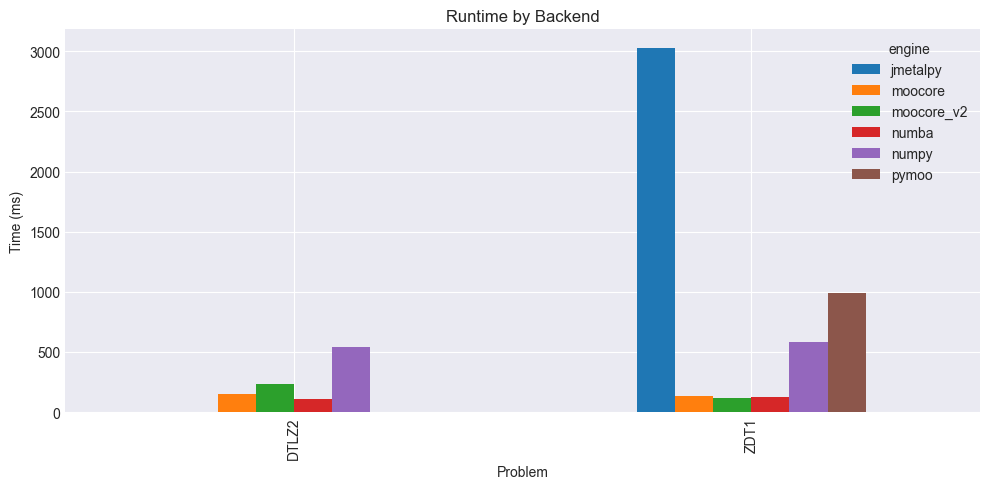

In [14]:
if summary_df.empty:
    print("No summary data yet. Run the benchmarking cell above first.")
else:
    pivot_time = summary_df.pivot(index="label", columns="engine", values="time_ms")
    ax = pivot_time.plot(kind="bar", figsize=(10, 5))
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("Problem")
    ax.set_title("Runtime by Backend")
    plt.tight_layout()
    plt.show()
